In [1]:
# SUPPLEMENT

# CLAIM: It likely that spurious gene boundaries only explain a small subset of the conflicts. 

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
from matplotlib.gridspec import GridSpec
from src.files import BLASTJsonFile
from src.reference import annotate
import re
import matplotlib.pyplot as plt 
from scipy.stats import mannwhitneyu
from utils import * 
from src.tools import RNACoFold

%load_ext autoreload 
%autoreload 2

In [3]:
START_CODONS = ['AUG', 'GUG', 'UUG']
STOP_CODONS = ['UAA', 'UAG', 'UGA']
MIN_LENGTH = 30 # Minimum allowed sequence length, in amino acids.

get_gc_content = lambda nt_seq : (nt_seq.count('G') + nt_seq.count('C')) / len(nt_seq)

# is_annotated_match = lambda df : df.match & (df.top_hit_product != 'hypothetical protein') & (~df.top_hit_pseudo)
is_annotated_match = lambda df : df.match & (df.top_hit_product != 'hypothetical protein') & (~df.top_hit_pseudo) & (df.top_hit_evidence_type == 'similar to AA sequence')
is_annotated_exact_match = lambda df : df.exact_match & (df.top_hit_product != 'hypothetical protein') & (~df.top_hit_pseudo) & (df.top_hit_evidence_type == 'similar to AA sequence')
is_n_terminal_extension = lambda df : (((df.query_start < df.top_hit_start) & (df.query_strand  == 1)) | ((df.query_stop > df.top_hit_stop) & (df.query_strand  == -1))) & df.match
is_c_terminal_extension = lambda df : (((df.query_start < df.top_hit_start) & (df.query_strand  == -1)) | ((df.query_stop > df.top_hit_stop) & (df.query_strand  == 1))) & df.match
is_annotated_n_terminal_extension = lambda df : is_n_terminal_extension(df) & is_annotated_match(df)
is_overlap_at_n_terminus = lambda overlap, strand : ((overlap == '01') and (strand == -1)) or ((overlap == '10') and (strand == 1))
is_overlap_at_c_terminus = lambda overlap, strand : ((overlap == '01') and (strand == 1)) or ((overlap == '10') and (strand == -1))

is_nested = lambda df : ((df.top_hit_overlap == '11') | (df.query_overlap == '11')) & is_cds_conflict(df)


def get_n_terminal_extension_length(row):
    try:
        assert row.match and (not row.exact_match), f'get_n_terminal_extension_length: Top hit and query sequences should be non-exact matches.'
        assert ((row.query_start < row.top_hit_start) and (row.query_strand  == 1)) or ((row.query_stop > row.top_hit_stop) and (row.query_strand  == -1)), f'get_n_terminal_extension_length: There is no extension.'
    except:
        return 0 
    
    if row.query_strand == 1:
        length = row.top_hit_start - row.query_start
    elif row.query_strand == -1:
        length = row.query_stop - row.top_hit_stop
    # This condition doesn't always hold when there is an assembly gap. 
    # assert (length % 3) == 0, f'get_n_terminal_extension_length: Extension length should be divisible by 3, got {length}.'
    return length / 3

def get_alternate_starts(nt_seq:str=None, codon_start:int=1, start_codons:list=['AUG', 'GUG']):
    
    nt_seq = nt_seq[int(codon_start) - 1:]
    
    codons = np.array([nt_seq[i:i + 3] for i in range(0, len(nt_seq) + 1, 3)])
    start_idxs = list(np.where(np.isin(codons, start_codons))[0])
    # WP_259095463.1 does not seem to have a start codon?
    if len(start_idxs) == 0:
        return [0]
    
    assert len(''.join(codons)) == len(nt_seq), 'get_alternate_starts: Joined codons should have the same length as the original nucleotide sequence.'

    if 0 not in start_idxs:
        start_idxs = [0] + start_idxs

    return start_idxs


def get_alternate_stops(id_, seq:str=None, blast_df:pd.DataFrame=None, min_percent_identity:float=0.8):

    stop_idxs = [len(seq)]

    blast_df = blast_df[(blast_df.subject_alignment_start < 3) | (blast_df.query_alignment_start < 3)].copy() # Make sure alignment starts at the N-termini, allowing alternate start selection.
    blast_df = blast_df[(blast_df.subject_length - blast_df.subject_alignment_stop < 3)].copy() # Make sure alignment extends to the subject C-terminus of the subject. 
    blast_df = blast_df[blast_df.percent_identity > min_percent_identity].copy() # Make sure alignment extends to the subject C-terminus of the subject. 

    df = blast_df[blast_df.index == id_].copy()
    df['truncation_length'] = df.query_length - df.query_alignment_stop
    df = df[df.truncation_length > 0].copy()
    df = df[(df.query_length - df.truncation_length) > MIN_LENGTH].copy() # Make sure the C-terminally truncated sequence meets the minimum length. 
    
    return stop_idxs + list(df.query_length - df.truncation_length) # Make sure to include the "no truncation" case.


In [4]:
dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)

dataset_df = annotate(dataset_df)
dataset_df['query_codon_start'] = 1
dataset_df['query_id'] = dataset_df.index
dataset_df['query_product'] = 'none'
dataset_df['query_rbs_motif'] = ~(dataset_df.query_rbs_motif.str.contains('T') |( dataset_df.query_rbs_motif == 'none'))
dataset_df['query_seq'] = dataset_df.seq
dataset_df['query_length'] = dataset_df.seq.apply(len) # Make sure these are in units of amino acids. 
dataset_df['top_hit_length'] = dataset_df.top_hit_seq.apply(len) # Make sure these are in units of amino acids. 
dataset_df['top_hit_id'] = dataset_df.top_hit_protein_id
dataset_df['top_hit_gc_content'] = dataset_df.top_hit_nt_seq.apply(get_gc_content)
dataset_df['query_seq'] = dataset_df.seq

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

In [5]:
print('Num. CDS conflicts:', is_cds_conflict(dataset_df).sum())
print('Num. non-nested CDS conflicts:', (is_cds_conflict(dataset_df) & ~is_nested(dataset_df)).sum())

Num. CDS conflicts: 483
Num. non-nested CDS conflicts: 398


In [6]:
# Considering the tandem configuration, errors which can result in hallucinated overlap are:
# (1) N-terminal (5') extension of the downstream gene; this is the most common (57% of overlaps > 60 bp)
# (2) Gene fragmentation due to a frameshift (23% of overlaps > 60 bp)
# (3) C-terminal (3') extension of the upstream gene due to frameshift at the 3' end or a mutation in the stop codon (9.5% of overlaps > 60 bp)
# (4) A combination of (1) and (3) (10% of overlaps > 60 bp)

# https://pmc.ncbi.nlm.nih.gov/articles/PMC2478687/

In [7]:
# Tandem overlaps 

tandem_dataset_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'tandem') & (~is_nested(dataset_df))].copy()
print('Num. tandem conflicts:', len(tandem_dataset_df))
write_fasta(tandem_dataset_df, path='../data/results/results-2/dataset_conflict_tandem.faa')

Num. tandem conflicts: 231
write_fasta: Wrote 462 sequences to ../data/results/results-2/dataset_conflict_tandem.faa


In [8]:
# BLASTp against NCBI clustered nr database, with the following parameters:
# Max. target sequences     10
# Expect threshold      0.005

tandem_blast_df = BLASTJsonFile('../data/results/results-2/conflict_tandem_blast.json').to_df()

def get_shared_blast_hit(row, blast_df:pd.DataFrame=tandem_blast_df, min_percent_identity:float=0.8):
    blast_df = blast_df[(blast_df.bit_score > 50) & (blast_df.percent_identity > min_percent_identity)].copy()

    shared_subject_ids = np.array([])
    if (row.query_id in blast_df.index) and row.top_hit_id in blast_df.index:
        shared_subject_ids = np.intersect1d(blast_df.loc[row.top_hit_id].subject_id, blast_df.loc[row.query_id].subject_id)
    if len(shared_subject_ids) == 0:
        return None
    # if len(shared_subject_ids) > 0:
    #     print(f'get_shared_blast_hit: Multiple shared BLAST hits for {row.query_id} and {row.top_hit_id}.')

    get_bit_score = lambda query_id, subject_id : blast_df[(blast_df.index == query_id) & (blast_df.subject_id == subject_id)].bit_score.iloc[0]
    get_percent_identity = lambda query_id, subject_id : blast_df[(blast_df.index == query_id) & (blast_df.subject_id == subject_id)].percent_identity.iloc[0]
    shared_subject_scores = [get_percent_identity(row.query_id, subject_id) + get_percent_identity(row.top_hit_id, subject_id) for subject_id in shared_subject_ids]
    # shared_subject_scores = [get_bit_score(row.query_id, subject_id) + get_bit_score(row.top_hit_id, subject_id) for subject_id in shared_subject_ids]
    shared_subject_ids = shared_subject_ids[np.argsort(shared_subject_scores)]
    return shared_subject_ids[-1] # Return the shared ID with the highest mean bit score. 

def is_fragmented(row, blast_df:pd.DataFrame=tandem_blast_df, min_percent_identity:float=0.8):
    return get_shared_blast_hit(row, blast_df=blast_df, min_percent_identity=min_percent_identity) is not None

tandem_dataset_df['fragmented'] = tandem_dataset_df.apply(is_fragmented, axis=1)
print('Num. tandem overlaps due to fragmentation:', tandem_dataset_df.fragmented.sum(), end='\n\n')

fragmented_ids = list(tandem_dataset_df[tandem_dataset_df.fragmented].index)
print(fragmented_ids)

Num. tandem overlaps due to fragmentation: 22

['NZ_JAALLS010000037.1_4', 'NZ_JAALLS010000005.1_1', 'NZ_JAYGHR010000002.1_180', 'NZ_JAYGHR010000010.1_46', 'NZ_JAYGHR010000095.1_4', 'NC_021487.1_586', 'NZ_JAIKTU010000005.1_51', 'NZ_QXIU01000121.1_2', 'NZ_QXIU01000013.1_4', 'NZ_QXIU01000201.1_20', 'NZ_QXIU01000258.1_3', 'NZ_QXIU01000037.1_8', 'NZ_QXIU01000048.1_21', 'NZ_QXIU01000073.1_4', 'NZ_QXIU01000088.1_2', 'NZ_CP130454.1_336', 'NZ_CP130454.1_2358', 'NZ_CP130454.1_3138', 'NZ_CP130454.1_3168', 'NC_014960.1_288', 'NC_014960.1_2737', 'NZ_AP035449.1_1439']


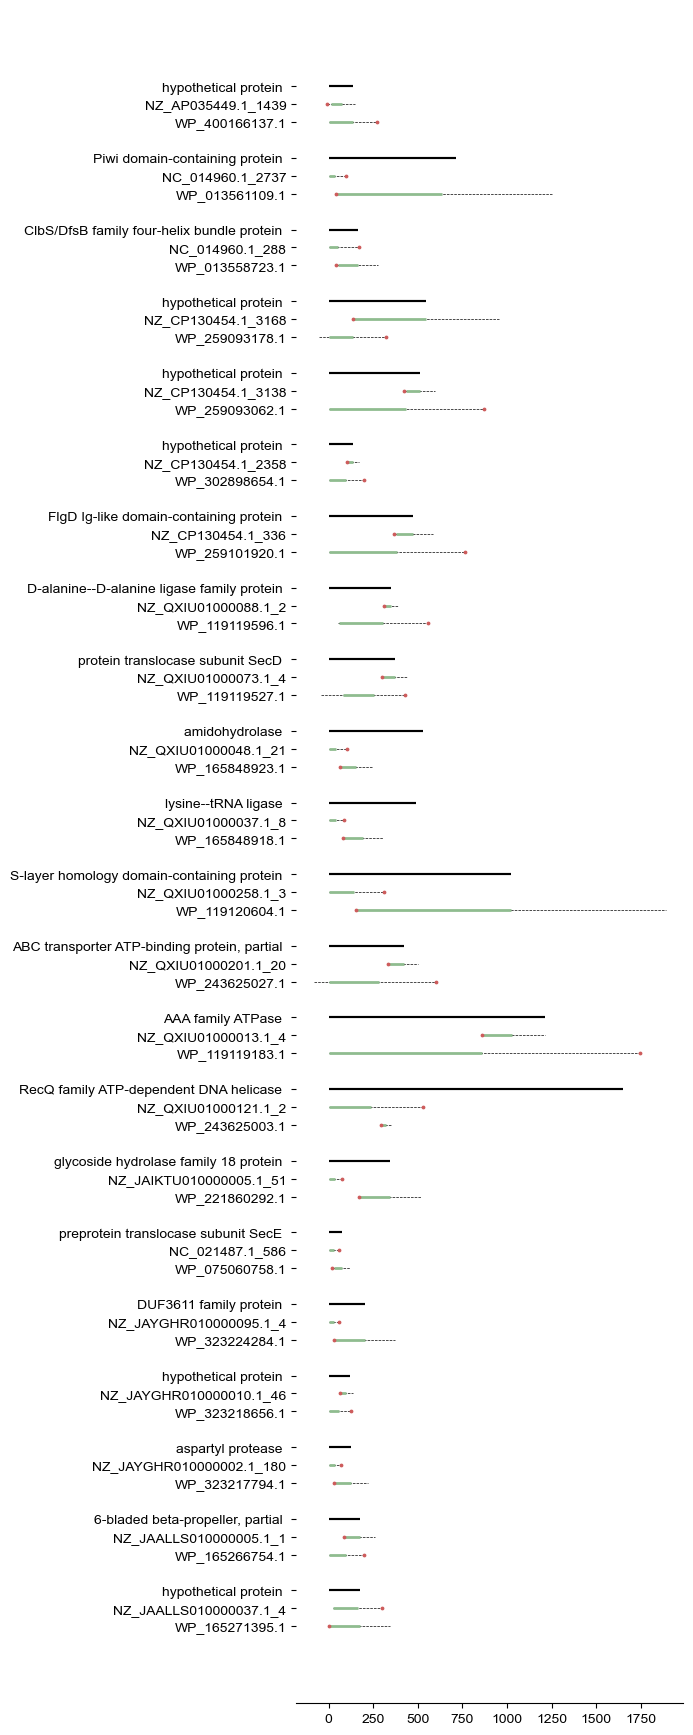

In [9]:
def figure(tandem_dataset_df:pd.DataFrame, tandem_blast_df:pd.DataFrame=tandem_blast_df):

    fig, ax = plt.subplots(figsize=(5, len(fragmented_ids)))

    def get_overlap_terminus(id_):
        prefix = 'top_hit' if (id_[0] == 'W') else 'query'
        overlap = tandem_dataset_df[tandem_dataset_df[f'{prefix}_id'] == id_][f'{prefix}_overlap'].iloc[0]
        strand = tandem_dataset_df[tandem_dataset_df[f'{prefix}_id'] == id_][f'{prefix}_strand'].iloc[0]
        assert overlap != '11', f'get_overlap_terminus: Not expecting a nested overlap, but got {overlap} for {id_}.'
        if ((overlap == '01') and (strand == 1)) or ((overlap == '10') and (strand == -1)):
            return -1
        else:
            return 0

    y_ticks, y_tick_labels = list(), list()
    for i, row in enumerate(tandem_dataset_df.loc[fragmented_ids].itertuples()):
        shared_subject_id = get_shared_blast_hit(row)
        
        offset = -0.25
        blast_df = tandem_blast_df[tandem_blast_df.index.isin([row.top_hit_id, row.query_id]) & (tandem_blast_df.subject_id == shared_subject_id)].copy()
        # Call 0 the start of the shared hit. 

        y_ticks.append(i)
        y_tick_labels.append(blast_df.subject_description.iloc[0])
        
        for row_ in blast_df.itertuples():

            query_length_before_alignment = row_.query_alignment_start
            query_length_after_alignment = row_.query_length - row_.query_alignment_start
            query_start, query_stop = row_.subject_alignment_start - query_length_before_alignment, row_.subject_alignment_stop + query_length_after_alignment

            y_ticks.append(i + offset)
            y_tick_labels.append(row_.Index)

            ax.hlines(i, xmin=0, xmax=row_.subject_length, color='black')
            ax.hlines(i + offset, xmin=query_start, xmax=query_stop, color='black', ls='--', lw=0.5)
            ax.hlines(i + offset, xmin=row_.subject_alignment_start, xmax=row_.subject_alignment_stop, color='darkseagreen', lw=2)
            ax.scatter([(query_start, query_stop)[get_overlap_terminus(row_.Index)]], [i + offset], color='indianred', zorder=100, s=3)
            offset -= 0.25

    ax.set_yticks(y_ticks, labels=y_tick_labels)
    for edge in ['top', 'left', 'right']:
        ax.spines[edge].set_visible(False)

    plt.show()

figure(tandem_dataset_df)

In [10]:

tandem_adjusted_conflict_df = list()

for row in [row.to_dict() for _, row in tandem_dataset_df[~tandem_dataset_df.fragmented].iterrows()]:

    downstream_prefix = 'top_hit' if is_overlap_at_n_terminus(row['top_hit_overlap'], row['top_hit_strand']) else 'query'
    upstream_prefix = 'top_hit' if is_overlap_at_c_terminus(row['top_hit_overlap'], row['top_hit_strand']) else 'query'

    start_idxs = get_alternate_starts(row[f'{downstream_prefix}_nt_seq'], codon_start=row[f'{downstream_prefix}_codon_start'])
    stop_idxs = get_alternate_stops(row[f'{upstream_prefix}_id'], seq=row[f'{upstream_prefix}_seq'], blast_df=tandem_blast_df)

    df = list()
    for start_idx in start_idxs:
        for stop_idx in stop_idxs:
            info = {'query_id':row['query_id'], 'top_hit_id':row['top_hit_id']}
            info[f'{upstream_prefix}_seq'] = row[f'{upstream_prefix}_seq'][:stop_idx]
            info[f'{downstream_prefix}_seq'] = row[f'{downstream_prefix}_seq'][start_idx:]
            info[f'{upstream_prefix}_nt_seq'] = row[f'{upstream_prefix}_nt_seq'][:stop_idx * 3]
            info[f'{downstream_prefix}_nt_seq'] = row[f'{downstream_prefix}_nt_seq'][start_idx * 3:]
            info[f'{upstream_prefix}_truncation_length'] = len(row[f'{upstream_prefix}_seq']) - len(info[f'{upstream_prefix}_seq'])
            info[f'{downstream_prefix}_truncation_length'] = len(row[f'{downstream_prefix}_seq']) - len(info[f'{downstream_prefix}_seq'])
            info['overlap_length'] = max(0, row['overlap_length'] - 3 * (info['query_truncation_length'] + info['top_hit_truncation_length']))
            info['original_overlap_length'] = row['overlap_length']
            info['total_truncation_length'] = info['query_truncation_length'] + info['top_hit_truncation_length']
            info[f'{downstream_prefix}_terminus'] = 'N' if (start_idx > 0) else 'none'
            info[f'{upstream_prefix}_terminus'] = 'C' if (stop_idx < len(row[f'{upstream_prefix}_seq'])) else 'none'
            df.append(info)

    df = pd.DataFrame(df)
    df['both_modified'] = (df.top_hit_terminus != 'none') & (df.query_terminus != 'none')
    tandem_adjusted_conflict_df.append(df.iloc[0].to_dict()) # Add the unmodified overlap to the main DataFrame. 

    df = df[(df.query_seq.apply(len) > MIN_LENGTH) & (df.top_hit_seq.apply(len) > MIN_LENGTH)].copy()
    df = df[df.total_truncation_length > 0].copy() # Only include things that could actually be adjusted.
    df = df.sort_values(['overlap_length', 'both_modified', 'total_truncation_length'], ascending=True) # Select options which minimize total truncation length.

    if len(df) == 0:
        continue 

    tandem_adjusted_conflict_df.append(df.iloc[0].to_dict())

tandem_adjusted_conflict_df = pd.DataFrame(tandem_adjusted_conflict_df)
tandem_adjusted_conflict_df['both_termini_truncation'] = (tandem_adjusted_conflict_df.query_terminus != 'none') & (tandem_adjusted_conflict_df.top_hit_terminus != 'none')
tandem_adjusted_conflict_df['n_terminal_truncation'] = ((tandem_adjusted_conflict_df.query_terminus == 'N') | (tandem_adjusted_conflict_df.top_hit_terminus == 'N')) & ~tandem_adjusted_conflict_df.both_termini_truncation
tandem_adjusted_conflict_df['c_terminal_truncation'] = ((tandem_adjusted_conflict_df.query_terminus == 'C') | (tandem_adjusted_conflict_df.top_hit_terminus == 'C')) & ~tandem_adjusted_conflict_df.both_termini_truncation

In [11]:
print('Num. tandem overlaps resolved by N-terminal truncation:', tandem_adjusted_conflict_df[tandem_adjusted_conflict_df.overlap_length == 0].n_terminal_truncation.sum())
print('Num. tandem overlaps resolved by C-terminal truncation:', tandem_adjusted_conflict_df[tandem_adjusted_conflict_df.overlap_length == 0].c_terminal_truncation.sum())
print('Num. tandem overlaps resolved by truncation at both termini:', tandem_adjusted_conflict_df[tandem_adjusted_conflict_df.overlap_length == 0].both_termini_truncation.sum())

# categories = ['fragmented', 'n_terminal_extension', 'c_terminal_extension']
# tandem_dataset_df['category'] = np.select([tandem_dataset_df[category] for category in categories], categories, default='none')

Num. tandem overlaps resolved by N-terminal truncation: 118
Num. tandem overlaps resolved by C-terminal truncation: 9
Num. tandem overlaps resolved by truncation at both termini: 0


In [12]:
# Convergent overlaps

# Convergent overlaps conflict at the 3' end of both genes, so could only be hallucinated by 3' extension of one or both genes. 
# The best way to assess the likelihood of a 3' extension is by searching for orthologs which align at the 5' end. 
 
convergent_dataset_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'convergent') & (~is_nested(dataset_df))].copy()
print('Num. convergent conflicts:', len(convergent_dataset_df))

write_fasta(convergent_dataset_df, path='../data/results/results-2/dataset_conflict_convergent.faa')

Num. convergent conflicts: 134
write_fasta: Wrote 268 sequences to ../data/results/results-2/dataset_conflict_convergent.faa


In [13]:
# BLASTp against NCBI clustered nr database, with the following parameters:
# Max. target sequences     10
# Expect threshold      0.005

convergent_blast_df = BLASTJsonFile('../data/results/results-2/conflict_convergent_blast.json').to_df()
convergent_blast_df = convergent_blast_df[convergent_blast_df.bit_score > 50].copy()

convergent_adjusted_conflict_df = list()

for row in convergent_dataset_df.itertuples():

    df = list()
    for query_stop_idx in get_alternate_stops(row.query_id, seq=row.query_seq, blast_df=convergent_blast_df):
        for top_hit_stop_idx in get_alternate_stops(row.top_hit_id, seq=row.top_hit_seq, blast_df=convergent_blast_df):
            info = {'query_id':row.query_id, 'top_hit_id':row.top_hit_id}
            info['query_seq'] = row.query_seq[:query_stop_idx]
            info['top_hit_seq'] = row.top_hit_seq[:top_hit_stop_idx]
            info['query_nt_seq'] = row.query_nt_seq[:3 * query_stop_idx]
            info['top_hit_nt_seq'] = row.top_hit_nt_seq[:3 * top_hit_stop_idx]
            info[f'query_truncation_length'] = len(row.query_seq) - len(info['query_seq'])
            info[f'top_hit_truncation_length'] = len(row.top_hit_seq) - len(info['top_hit_seq'])
            info['overlap_length'] = max(0, row.overlap_length - 3 * (info['query_truncation_length'] + info['top_hit_truncation_length']))
            info['original_overlap_length'] = row.overlap_length
            info['total_truncation_length'] = info['query_truncation_length'] + info['top_hit_truncation_length']
            info[f'query_terminus'] = 'C' if (query_stop_idx < len(row.query_seq)) else 'none'
            info[f'top_hit_terminus'] = 'C' if (top_hit_stop_idx < len(row.top_hit_seq)) else 'none'
            df.append(info)

    df = pd.DataFrame(df)
    df['both_modified'] = (df.top_hit_terminus != 'none') & (df.query_terminus != 'none')
    convergent_adjusted_conflict_df.append(df.iloc[0].to_dict()) # Add the unmodified overlap to the main DataFrame. 

    df = df[(df.query_seq.apply(len) > MIN_LENGTH) & (df.top_hit_seq.apply(len) > MIN_LENGTH)].copy()
    df = df[df.total_truncation_length > 0].copy() # Only include things that could actually be adjusted.
    df = df.sort_values(['overlap_length', 'both_modified', 'total_truncation_length'], ascending=True) # Select options which minimize total truncation length.

    if len(df) == 0:
        continue 

    convergent_adjusted_conflict_df.append(df.iloc[0].to_dict())

    if len(df) > 0:
        convergent_adjusted_conflict_df.append(df.iloc[0].to_dict())

convergent_adjusted_conflict_df = pd.DataFrame(convergent_adjusted_conflict_df)

print('Num. resolved convergent overlaps:', (convergent_adjusted_conflict_df.overlap_length == 0).sum())
assert ((convergent_adjusted_conflict_df.query_terminus == 'none') & (convergent_adjusted_conflict_df.top_hit_terminus == 'none')).sum() == len(convergent_dataset_df)

Num. resolved convergent overlaps: 38


In [14]:
# Divergent overlaps

# Divergent overlaps conflict at the 5' ends of both genes, so can only be hallucinated by 5' extension of one or both genes. 
# Whether or not a divergent overlap is hallucinated can be tested by searching for an alternate start site. 
 
divergent_dataset_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'divergent') & ~is_nested(dataset_df)].copy()
print('Num. divergent conflicts:', len(divergent_dataset_df))

Num. divergent conflicts: 33


In [15]:
divergent_adjusted_conflict_df = list()

for row in divergent_dataset_df.itertuples():

    df = list()
    for query_start_idx in get_alternate_starts(row.query_nt_seq, codon_start=row.query_codon_start):
        for top_hit_start_idx in get_alternate_starts(row.top_hit_nt_seq, codon_start=row.top_hit_codon_start):
            info = {'query_id':row.query_id, 'top_hit_id':row.top_hit_id}
            # In order for an overlap to be "resolved," the sum of the alternate start indices needs to exceed the overlap length. 
            info['query_seq'] = row.query_seq[query_start_idx:]
            info['top_hit_seq'] = row.top_hit_seq[top_hit_start_idx:]
            info['query_nt_seq'] = row.query_nt_seq[3 * query_start_idx:]
            info['top_hit_nt_seq'] = row.top_hit_nt_seq[3 * top_hit_start_idx:]
            info[f'query_truncation_length'] = len(row.query_seq) - len(info['query_seq'])
            info[f'top_hit_truncation_length'] = len(row.top_hit_seq) - len(info['top_hit_seq'])
            info['overlap_length'] = max(0, row.overlap_length - 3 * (info['query_truncation_length'] + info['top_hit_truncation_length']))
            info['original_overlap_length'] = row.overlap_length
            info['total_truncation_length'] = info['query_truncation_length'] + info['top_hit_truncation_length']
            info[f'query_terminus'] = 'N' if (query_start_idx > 0) else 'none'
            info[f'top_hit_terminus'] = 'N' if (top_hit_start_idx > 0) else 'none'
            df.append(info)

    df = pd.DataFrame(df)
    df['both_modified'] = (df.top_hit_terminus != 'none') & (df.query_terminus != 'none')
    divergent_adjusted_conflict_df.append(df.iloc[0].to_dict()) # Add the unmodified overlap to the main DataFrame. 

    df = df[(df.query_seq.apply(len) > MIN_LENGTH) & (df.top_hit_seq.apply(len) > MIN_LENGTH)].copy()
    df = df[df.total_truncation_length > 0].copy() # Only include things that could actually be adjusted.
    df = df.sort_values(['overlap_length', 'both_modified', 'total_truncation_length'], ascending=True) # Select options which minimize total truncation length.

    if len(df) == 0:
        continue 

    divergent_adjusted_conflict_df.append(df.iloc[0].to_dict())

divergent_adjusted_conflict_df = pd.DataFrame(divergent_adjusted_conflict_df)

print('Num. resolved divergent overlaps:', (divergent_adjusted_conflict_df.overlap_length == 0).sum())
assert ((divergent_adjusted_conflict_df.query_terminus == 'none') & (divergent_adjusted_conflict_df.top_hit_terminus == 'none')).sum() == len(divergent_dataset_df)
    

Num. resolved divergent overlaps: 29


In [35]:
adjusted_conflict_df = list()

dfs = dict()
dfs['convergent'] = convergent_adjusted_conflict_df
dfs['divergent'] = divergent_adjusted_conflict_df
dfs['tandem'] = tandem_adjusted_conflict_df

for overlap_type, df in dfs.items():
    for _, row in df.iterrows():
        for prefix in ['top_hit', 'query']:
            info = {key.replace(f'{prefix}_', ''):value for key, value in row.to_dict().items() if (prefix in key)}
            info['overlap_type'] = overlap_type
            info['overlap_length'] = row.overlap_length
            info['original_overlap_length'] = row.original_overlap_length
            info['conflict_id'] = getattr(row, 'top_hit_id' if (prefix == 'query') else 'query_id')
            adjusted_conflict_df.append(info)


adjusted_conflict_df = pd.DataFrame(adjusted_conflict_df)
adjusted_conflict_df['pair_id'] = ['+'.join(sorted([row.conflict_id, getattr(row, 'id')])) for row in adjusted_conflict_df.itertuples()]
adjusted_conflict_df['gc_content'] = adjusted_conflict_df.nt_seq.apply(get_gc_content)
adjusted_conflict_df = adjusted_conflict_df.reset_index()
adjusted_conflict_df.index.name = 'index'

for field in ['genome_id', 'species']:
    map_ = {id_:value for id_, value in zip(dataset_df.index, dataset_df[field])}
    map_.update({id_:species for id_, species in zip(dataset_df.top_hit_protein_id, dataset_df[field])})
    adjusted_conflict_df[field] = adjusted_conflict_df['id'].map(map_)

map_ = {id_:value for id_, value in zip(dataset_df.index, dataset_df['query_rbs_min_free_energy'])}
map_.update({id_:value for id_, value in zip(dataset_df.top_hit_protein_id, dataset_df['top_hit_rbs_min_free_energy'])})
adjusted_conflict_df['rbs_min_free_energy'] = adjusted_conflict_df['id'].map(map_)

# adjusted_conflict_df = adjusted_conflict_df.drop_duplicates(subset=['id', 'terminus'])
adjusted_conflict_df = adjusted_conflict_df.drop_duplicates(subset=['seq'])
adjusted_conflict_df.set_index('index').to_csv('../data/results/results-2/adjusted_conflict.csv')

In [34]:
len(adjusted_conflict_df)

969

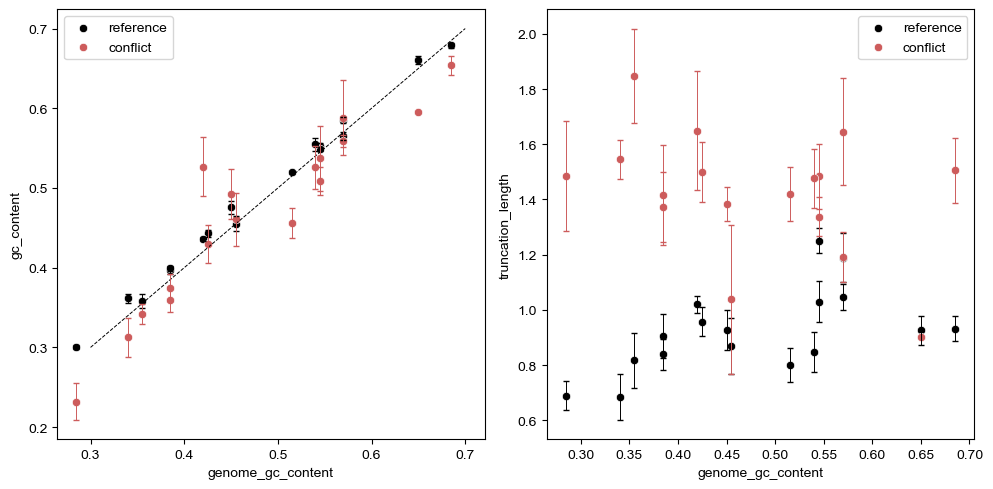

In [17]:

def figure(dataset_df:pd.DataFrame, adjusted_conflict_df:pd.DataFrame):

    figure_df = pd.DataFrame(index=pd.Index(dataset_df.species.unique()))
    figure_df['annotated_match_gc_content'] = dataset_df[is_annotated_match(dataset_df)].groupby('species').top_hit_gc_content.mean()
    figure_df['genome_gc_content'] = dataset_df[is_annotated_match(dataset_df)].groupby('species').gc_percent.first() / 100
    figure_df['annotated_exact_match_gc_content'] = dataset_df[is_annotated_exact_match(dataset_df)].groupby('species').top_hit_gc_content.mean()

    fig, axes = plt.subplots(figsize=(10, 5), ncols=2)


    # Select the sequences which can be truncated at the N-terminus to resolve the conflict. 
    adjusted_conflict_df = adjusted_conflict_df[(adjusted_conflict_df.terminus == 'N') & (adjusted_conflict_df.overlap_length == 0)].copy()
    adjusted_conflict_df['truncation_length'] = np.log10(adjusted_conflict_df.truncation_length)
    dataset_df = dataset_df[is_annotated_match(dataset_df) & is_n_terminal_extension(dataset_df)].copy()
    dataset_df = dataset_df.rename(columns={'top_hit_gc_content':'gc_content'})
    dataset_df['truncation_length'] = np.log10(dataset_df.apply(get_n_terminal_extension_length, axis=1))

    for ax, var in zip(axes, ['gc_content', 'truncation_length']):


        figure_df['annotated_n_terminal_extension_count'] = dataset_df.groupby('species').apply(len, include_groups=False)
        figure_df[f'annotated_n_terminal_extension_{var}_mean'] = dataset_df.groupby('species')[var].mean()
        figure_df[f'annotated_n_terminal_extension_{var}_std'] = dataset_df.groupby('species')[var].std()
        figure_df[f'annotated_n_terminal_extension_{var}_err'] = figure_df[f'annotated_n_terminal_extension_{var}_std'] / np.sqrt(figure_df.annotated_n_terminal_extension_count)

        figure_df['conflict_n_terminal_extension_count'] = adjusted_conflict_df.groupby('species').apply(len, include_groups=False)
        figure_df[f'conflict_n_terminal_extension_{var}_mean'] = adjusted_conflict_df.groupby('species')[var].mean()
        figure_df[f'conflict_n_terminal_extension_{var}_std'] = adjusted_conflict_df.groupby('species')[var].std()
        figure_df[f'conflict_n_terminal_extension_{var}_err'] = figure_df[f'conflict_n_terminal_extension_{var}_std'] / np.sqrt(figure_df.conflict_n_terminal_extension_count)

    
        sns.scatterplot(figure_df, x=f'genome_gc_content', y=f'annotated_n_terminal_extension_{var}_mean', color='black', label='reference', ax=ax)
        ax.errorbar(figure_df['genome_gc_content'], figure_df[f'annotated_n_terminal_extension_{var}_mean'], yerr=figure_df[f'annotated_n_terminal_extension_{var}_err'], ls='', lw=0.7, color='black', capsize=2, zorder=10)
        sns.scatterplot(figure_df, x='genome_gc_content', y=f'conflict_n_terminal_extension_{var}_mean', color='indianred', label='conflict', ax=ax)
        ax.errorbar(figure_df['genome_gc_content'], figure_df[f'conflict_n_terminal_extension_{var}_mean'], yerr=figure_df[f'conflict_n_terminal_extension_{var}_err'], ls='', lw=0.7, color='indianred', capsize=2, zorder=10)
        
        if var == 'gc_content':
            sns.lineplot(x=np.linspace(0.3, 0.7, 10), y=np.linspace(0.3, 0.7, 10), ls='--', color='black', lw=0.7, ax=ax)

        ax.legend()
        ax.set_ylabel(var)
        
    fig.tight_layout()
    plt.show()

figure(dataset_df, adjusted_conflict_df)

In [18]:
# Want to establish that there is apparently no connection between whether or not a gene is N-terminally extended and the GC content of the gene. 

df = dataset_df[is_annotated_exact_match(dataset_df) | is_annotated_n_terminal_extension(dataset_df)].copy()
df['category'] = np.select([is_annotated_exact_match(df), is_annotated_n_terminal_extension(df)], ['exact_match', 'n_terminal_extension'], default='none')
df['genome_gc_content'] = df.species.map(df.groupby('species').gc_percent.first())
df['gc_content'] = df.top_hit_nt_seq.apply(get_gc_content)
df['gc_content_normalized'] = df.top_hit_nt_seq.apply(get_gc_content) / df.genome_gc_content

p = mannwhitneyu(df[df.category == 'exact_match'].gc_content_normalized.values, df[df.category == 'n_terminal_extension'].gc_content_normalized.values).pvalue
print(f'p={p:.5f}')


p=0.44619


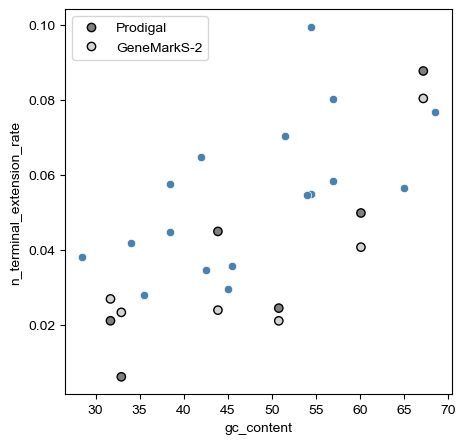

In [19]:

def figure(dataset_df:pd.DataFrame):

    fig, ax = plt.subplots(figsize=(5, 5))

    dimonaco_df = pd.read_csv('../data/dimonaco_2020.csv') # Load in data from "No one tool to rule them all" paper.
    dimonaco_df['n_terminal_extension_rate'] = dimonaco_df.num_n_terminal_extension / dimonaco_df.num_match
    dimonaco_df['n_terminal_extension_rate'] = dimonaco_df.num_n_terminal_extension / dimonaco_df.num_match
    dimonaco_df['n_terminal_truncation_rate'] = (dimonaco_df.num_match - (dimonaco_df.num_perfect_starts + dimonaco_df.num_n_terminal_extension)) / dimonaco_df.num_match

    palette = {'Prodigal':'gray', 'GeneMarkS-2':'lightgray'}
    sns.scatterplot(dimonaco_df, x='gc_content', y='n_terminal_extension_rate', hue='tool', legend=True, palette=palette, edgecolor='black', lw=1)
    # sns.scatterplot(dimonaco_df, x='gc_content', y='n_terminal_truncation_rate', hue='tool', marker='v', legend=False, s=50, palette=palette)

    figure_df = pd.DataFrame(index=pd.Index(dataset_df.species.unique()))
    figure_df['num_n_terminal_extension'] = dataset_df[is_annotated_n_terminal_extension(dataset_df)].groupby('species').apply(len, include_groups=False)
    figure_df['total'] = dataset_df[is_annotated_match(dataset_df)].groupby('species').apply(len, include_groups=False)
    figure_df['gc_content'] = dataset_df.groupby('species').gc_percent.first()
    figure_df['n_terminal_extension_rate'] = dataset_df.groupby('species').apply(lambda df : is_annotated_n_terminal_extension(df).sum() / is_annotated_match(df).sum(), include_groups=False)

    sns.scatterplot(figure_df, x='gc_content', y='n_terminal_extension_rate', color='steelblue', legend=True)
    plt.show()


figure(dataset_df)


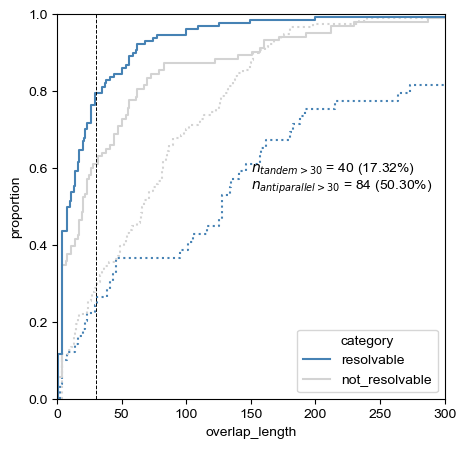

In [26]:
resolvable_ids = adjusted_conflict_df[adjusted_conflict_df.overlap_length == 0]['id'].values 

is_resolvable_conflict = lambda df : df.top_hit_id.isin(resolvable_ids) | df.query_id.isin(resolvable_ids)

figure_df = dataset_df[is_cds_conflict(dataset_df) & ~is_nested(dataset_df)].copy()
figure_df['resolvable'] = is_resolvable_conflict(figure_df)
figure_df['category'] = np.where(figure_df.resolvable, 'resolvable', 'not_resolvable')

fig, ax = plt.subplots(figsize=(5, 5))

palette = {'resolvable':'steelblue', 'not_resolvable':'lightgray'}
sns.ecdfplot(figure_df[~figure_df.same_strand], x='overlap_length', hue='category', palette=palette, ls=':')
sns.ecdfplot(figure_df[figure_df.same_strand], x='overlap_length', hue='category', palette=palette)

overlap_length = 30
ax.axvline(overlap_length, ls='--', color='black', lw=0.7)

text = get_text(f'tandem > {overlap_length}', (figure_df.same_strand & ~figure_df.resolvable & (figure_df.overlap_length > overlap_length)).sum(), figure_df.same_strand.sum())
text += get_text(f'antiparallel > {overlap_length}', (~figure_df.same_strand & ~figure_df.resolvable & (figure_df.overlap_length > overlap_length)).sum(), (~figure_df.same_strand).sum())
ax.text(0.5, 0.5, text, transform=ax.transAxes)
ax.set_ylabel('proportion')

ax.set_xlim(xmax=300, xmin=0)
plt.show()

In [21]:
# # I also want to check on the strength of the ribosome binding sites, also normalized relative to genome RBS binding strength. 
# # Will use this instead of presence/absence to have continuous values, as well as account for genome differences more easily. 

# if ('query_rbs_min_free_energy' not in dataset_df.columns) or ('top_hit_rbs_min_free_energy' not in dataset_df.columns):
#     rnacofold = RNACoFold()
#     query_rnacofold_df = rnacofold.run(dataset_df, seq_col='query_nt_seq_upstream')
#     top_hit_rnacofold_df = rnacofold.run(dataset_df, seq_col='top_hit_nt_seq_upstream')
#     rnacofold.cleanup()
    
#     dataset_df['query_rbs_min_free_energy'] = query_rnacofold_df.mfe
#     dataset_df['top_hit_rbs_min_free_energy'] = top_hit_rnacofold_df.mfe

#     df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)
#     df['query_rbs_min_free_energy'] = query_rnacofold_df.mfe
#     df['top_hit_rbs_min_free_energy'] = top_hit_rnacofold_df.mfe
#     df.to_csv('../data/results/results-2/dataset.csv')
    

# df = dataset_df[is_annotated_exact_match(dataset_df) | is_annotated_n_terminal_extension(dataset_df)].copy()
# df['rbs_min_free_energy'] = df.query_rbs_min_free_energy
# df['category'] = np.select([is_annotated_exact_match(df), is_annotated_n_terminal_extension(df)], ['exact_match', 'n_terminal_extension'], default='none')
# df = df[['species', 'rbs_min_free_energy', 'category']].copy()

# mask = (adjusted_conflict_df.terminus == 'N') & (adjusted_conflict_df.overlap_length == 0)
# df = pd.concat([adjusted_conflict_df[mask][['rbs_min_free_energy', 'species']].assign(category='conflict'), df], axis=0)

# df['genome_rbs_min_free_energy'] = df.species.map(df.groupby('species').rbs_min_free_energy.mean())
# df['rbs_min_free_energy_normalized'] = df.rbs_min_free_energy / df.genome_rbs_min_free_energy

# # p = mannwhitneyu(df[df.category == 'exact_match'].rbs_min_free_energy_normalized.values, df[df.category == 'n_terminal_extension'].rbs_min_free_energy_normalized.values).pvalue
# p = mannwhitneyu(df[df.category == 'exact_match'].rbs_min_free_energy.values, df[df.category == 'n_terminal_extension'].rbs_min_free_energy.values).pvalue
# print(f'p={p:.7f}', end='\n\n')

# p = mannwhitneyu(df[df.category == 'n_terminal_extension'].rbs_min_free_energy.values, df[df.category == 'conflict'].rbs_min_free_energy_normalized.values).pvalue
# print(f'p={p:.7f}')

# # We do observe a statistically-significant difference in the RBS strength; sequences which are N-terminally extended tend to have
# # weaker RBS. One potential explanation for this is that the original sequences lack an RBS, so Prodigal looks for the "best" RBS it can find, 
# # resulting in erroneous start-site selection. 

# # fig, ax = plt.subplots(figsize=(5, 5))
# # sns.ecdfplot(df, x='rbs_min_free_energy_normalized', hue='category', palette={'exact_match':'black', 'conflict':'indianred', 'n_terminal_extension':'gray'})
# # ax.set_xlim(xmin=0, xmax=3)
# # plt.show()

In [22]:
# figure_df = pd.DataFrame(index=pd.Index(dataset_df.species.unique()))
# figure_df['genome_rbs_min_free_energy'] = dataset_df[is_annotated_exact_match(dataset_df)].groupby('species').query_rbs_min_free_energy.mean()

# figure_df['reference_n_terminal_extension_rbs_min_free_energy_count'] = dataset_df[is_annotated_n_terminal_extension(dataset_df)].groupby('species').size()
# figure_df['reference_n_terminal_extension_rbs_min_free_energy_mean'] = dataset_df[is_annotated_n_terminal_extension(dataset_df)].groupby('species').query_rbs_min_free_energy.mean()
# figure_df['reference_n_terminal_extension_rbs_min_free_energy_std'] = dataset_df[is_annotated_n_terminal_extension(dataset_df)].groupby('species').query_rbs_min_free_energy.std()
# figure_df['reference_n_terminal_extension_rbs_min_free_energy_err'] = figure_df.reference_n_terminal_extension_rbs_min_free_energy_std / np.sqrt(figure_df.reference_n_terminal_extension_rbs_min_free_energy_count)

# figure_df['conflict_n_terminal_extension_rbs_min_free_energy_count'] = adjusted_conflict_df[(adjusted_conflict_df.terminus == 'N') & (adjusted_conflict_df.overlap_length == 0)].groupby('species').size()
# figure_df['conflict_n_terminal_extension_rbs_min_free_energy_mean'] = adjusted_conflict_df[(adjusted_conflict_df.terminus == 'N') & (adjusted_conflict_df.overlap_length == 0)].groupby('species').rbs_min_free_energy.mean()
# figure_df['conflict_n_terminal_extension_rbs_min_free_energy_std'] = adjusted_conflict_df[(adjusted_conflict_df.terminus == 'N') & (adjusted_conflict_df.overlap_length == 0)].groupby('species').rbs_min_free_energy.std()
# figure_df['conflict_n_terminal_extension_rbs_min_free_energy_err'] = figure_df.conflict_n_terminal_extension_rbs_min_free_energy_std / np.sqrt(figure_df.conflict_n_terminal_extension_rbs_min_free_energy_count)

# fig, ax = plt.subplots(figsize=(5, 5))
# sns.scatterplot(figure_df, x='genome_rbs_min_free_energy', y='reference_n_terminal_extension_rbs_min_free_energy_mean', color='black')
# sns.scatterplot(figure_df, x='genome_rbs_min_free_energy', y='conflict_n_terminal_extension_rbs_min_free_energy_mean', color='indianred')
# sns.lineplot(x=np.linspace(-10, -2, 10), y=np.linspace(-10, -2, 10), ls='--', color='black', lw=0.7)

# ax.errorbar(figure_df['genome_rbs_min_free_energy'], figure_df[f'reference_n_terminal_extension_rbs_min_free_energy_mean'], yerr=figure_df[f'reference_n_terminal_extension_rbs_min_free_energy_err'], ls='', lw=0.7, color='black', capsize=2, zorder=10)
# ax.errorbar(figure_df['genome_rbs_min_free_energy'], figure_df[f'conflict_n_terminal_extension_rbs_min_free_energy_mean'], yerr=figure_df[f'conflict_n_terminal_extension_rbs_min_free_energy_err'], ls='', lw=0.7, color='indianred', capsize=2, zorder=10)

# plt.show()

In [23]:
# figure_df = pd.DataFrame(index=pd.Index(dataset_df.species.unique(), name='genome_id'))
# figure_df['gc_percent'] = dataset_df.groupby('species').gc_percent.first() / 100
# figure_df['genome_size'] = dataset_df.groupby('species').apply(len, include_groups=False)
# figure_df['n_annotated_match'] = dataset_df.groupby('species').apply(lambda df : is_annotated_match(df).sum(), include_groups=False)
# figure_df['n_cds_conflicts'] = dataset_df.groupby('species').apply(lambda df : is_cds_conflict(df).sum(), include_groups=False)
# # figure_df['false_positive_rate'] = dataset_df.groupby('species').apply(lambda df : (~df.match).sum() / len(df), include_groups=False)
# figure_df['n_annotated_match_with_rbs'] = dataset_df.groupby('species').apply(lambda df : (is_annotated_match(df) & df.query_rbs_motif).sum(), include_groups=False)
# figure_df['rbs_content'] = figure_df.n_annotated_match_with_rbs / figure_df.n_annotated_match
# figure_df['n_terminal_extension_rate'] = dataset_df.groupby('species').apply(lambda df : is_n_terminal_extension(df).sum() / is_annotated_match(df).sum(), include_groups=False)

# figure_df['n_tandem_conflicts'] = tandem_dataset_df.groupby('species').apply(len, include_groups=False) 
# figure_df['n_divergent_conflicts'] = divergent_dataset_df.groupby('species').apply(len, include_groups=False)
# figure_df['n_convergent_conflicts'] = convergent_dataset_df.groupby('species').apply(len, include_groups=False)

# for overlap_type in ['tandem', 'convergent', 'divergent']:
#     figure_df[f'n_{overlap_type}_conflicts_normalized'] = figure_df[f'n_{overlap_type}_conflicts'] / figure_df.n_cds_conflicts

# figure_df = figure_df.fillna(0)

# fig, ax = plt.subplots(figsize=(5, 5))

# palette = {'convergent':'gray', 'tandem':'lightgray', 'divergent':'black'}

# x = 'gc_percent'

# text = '' 

# for overlap_type in ['tandem', 'convergent', 'divergent']:
#     r = np.corrcoef(figure_df[x].values.ravel(), figure_df[f'n_{overlap_type}_conflicts_normalized'].values.ravel())[0, 1] ** 2
#     text += r'$R^2_{' + overlap_type + '}$ = ' + f'{r:.2f}\n'
#     # sns.scatterplot(figure_df, x=x, y=f'n_{overlap_type}_conflicts_normalized', ax=ax, label=overlap_type, c=palette[overlap_type])
#     sns.scatterplot(figure_df, x=x, y=f'n_{overlap_type}_conflicts', ax=ax, label=overlap_type, c=palette[overlap_type])

# ax.text(0.5, 0.5, text, transform=ax.transAxes)
# ax.set_ylabel('count')
# ax.legend()
# sns.move_legend(ax, loc='upper left')

# fig.tight_layout()

# plt.show()

In [24]:
# def figure(tandem_dataset_df:pd.DataFrame):

#     fig, ax = plt.subplots(figsize=(5, 5))

#     palette = {'none':'indianred', 'c_terminal_extension':'lightgray', 'n_terminal_extension':'gray', 'fragmented':'black'}

#     for category, df in tandem_dataset_df.groupby('category'):
#         sns.ecdfplot(df, x='overlap_length', c=palette[category], ls=':' if (category == 'fragmented') else '-', label=f'{category} (n={len(df)})', ax=ax)
#     ax.legend()

#     n = ((tandem_dataset_df.category == 'none') & (tandem_dataset_df.overlap_length > 30)).sum() 
#     text = '$n_{none > 30} =$' + str(n) + f' ({get_percent(n, (tandem_dataset_df.category == 'none').sum())})'
#     n = ((tandem_dataset_df.category == 'none') & (tandem_dataset_df.overlap_length <5)).sum() 
#     text += '\n$n_{none < 5} =$' + str(n) + f' ({get_percent(n, (tandem_dataset_df.category == 'none').sum())})'

#     ax.text(0.5, 0.5, text, transform=ax.transAxes)
#     ax.set_ylabel('proportion')

#     plt.show()

# figure(tandem_dataset_df)

In [25]:
# def figure(dataset_df, adjusted_conflict_df):

#     dataset_df['rbs_min_free_energy'] = dataset_df.query_rbs_min_free_energy
#     adjusted_conflict_df = adjusted_conflict_df[(adjusted_conflict_df.terminus == 'N') & (adjusted_conflict_df.overlap_length == 0)].copy()

#     species = adjusted_conflict_df.groupby('species').size().sort_values(ascending=False).index[:5]
#     # species = dataset_df[is_annotated_exact_match(dataset_df)].groupby('species').rbs_min_free_energy.mean().sort_values(ascending=True).index[:5]
#     adjusted_conflict_df = adjusted_conflict_df[adjusted_conflict_df.species.isin(species)].copy()
#     dataset_df = dataset_df[dataset_df.species.isin(species)].copy()
    
#     dfs = dict()
#     dfs['reference_exact_match'] = dataset_df[is_annotated_exact_match(dataset_df)]
#     dfs['reference_n_terminal_extension'] = dataset_df[is_annotated_n_terminal_extension(dataset_df)]
#     dfs['conflict'] = adjusted_conflict_df

#     figure_df = list()
#     for category, df in dfs.items():
#         figure_df.append(df[['species', 'rbs_min_free_energy']].copy().assign(category=category))
#     figure_df = pd.concat(figure_df)

#     fig, ax = plt.subplots(figsize=(10, 5))
#     palette = {'reference_exact_match':'darkseagreen', 'reference_n_terminal_extension':'lightgray', 'conflict':'indianred'}
#     sns.violinplot(figure_df, hue='category', x='species', y='rbs_min_free_energy', palette=palette, ax=ax, inner='box', common_norm=False)
#     ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
#     plt.show()

# figure(dataset_df, adjusted_conflict_df)
